In [ ]:
''' HUMAN EVALUATION '''

In [240]:
import pickle as pkl
import numpy as np
import os

root = '/home/lioruzan/human_validation/all'
runs = [[] for j in range(8)]
for i in range(8):
    if i==7: continue # nothing in orientation 7
    r=root
    p = os.path.join(r,'results_{}_human_eval_dir{}.pkl'.format(0,i))
    with open(p,'rb') as f:
        runs[i].append(pkl.load(f))

In [241]:
# format of pickled files: {'gen_data': ( sample_x, x, m, sample_prob, colored_x ), 'size': size}
samps = []
datas = []
masks = []
colrs = []
probs = []
# collect generates samples from all 8 models for each experiment (20 total)
for j in range(1):
    samp = np.zeros((0,32,32,1),dtype=np.float32)
    data = samp.copy()
    mask = samp.copy().astype(np.int32)
    colr = np.zeros((0,32,32,3),dtype=np.float32)
    prob = np.zeros(len(data), dtype=np.float32)
    for i in range(8):
        if i==7: continue
        gen_data = runs[i][j]['gen_data']
        cutoff = runs[i][j]['size']
        total = len(gen_data) * len(gen_data[0][0])
        e = total-cutoff
        c = 1
        for sample_x, x, m, sample_prob, colored_x in gen_data:
            if c == len(gen_data):
                sample_x = sample_x[:-e]
                x = x[:-e]
                m = m[:-e]
                colored_x = colored_x[:-e]
                sample_prob[0] = sample_prob[0][:-e]
            samp = np.vstack([samp, sample_x])
            data = np.vstack([data, x])
            mask = np.vstack([mask, m])
            colr = np.vstack([colr, colored_x])
            prob = np.concatenate([prob, sample_prob[0]])
            c += 1
    samps.append(samp)
    datas.append(data)
    masks.append(mask)
    colrs.append(colr)
    probs.append(prob)

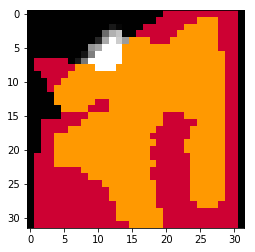

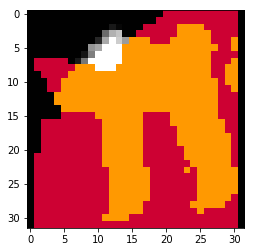

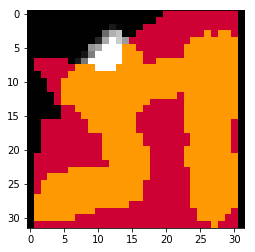

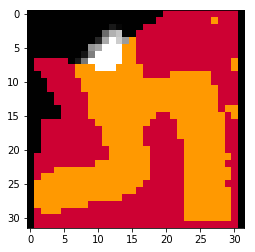

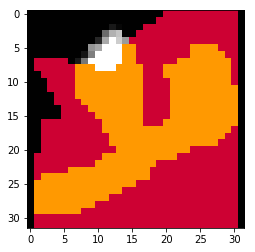

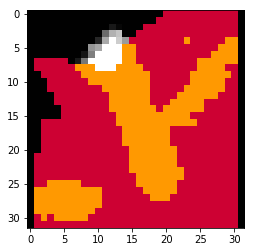

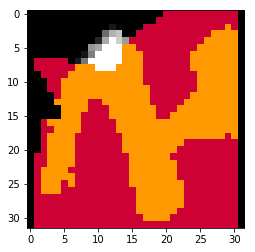

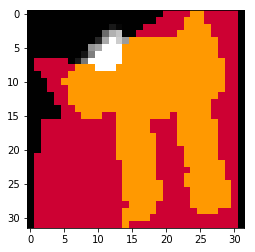

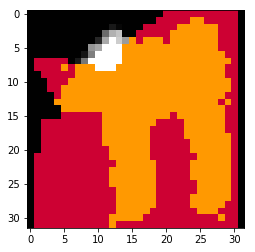

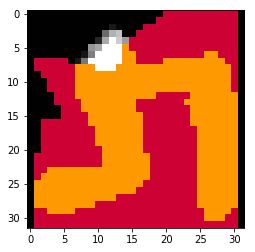

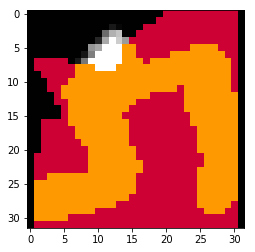

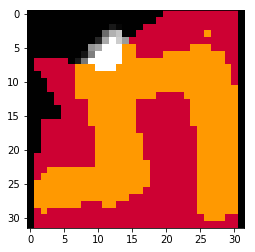

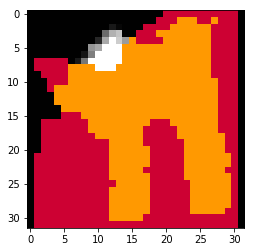

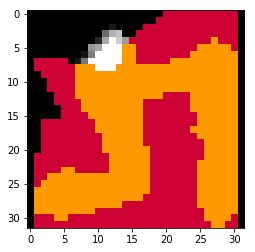

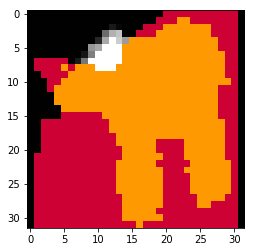

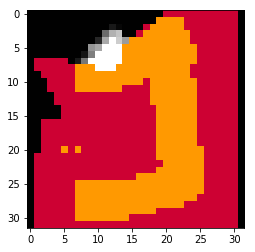

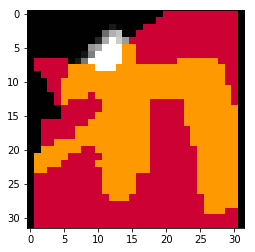

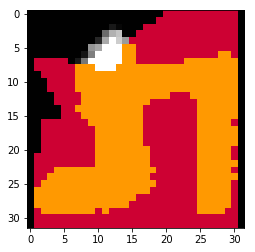

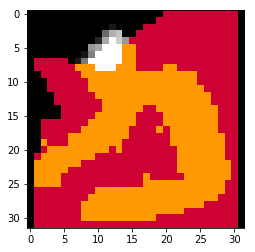

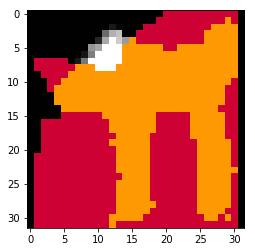

In [248]:
for j in range(20,40):
    plt.imshow(colrs[0][j].squeeze())
    plt.show()

In [227]:
''' UNSORT PICTURES '''
with open('/home/lioruzan/tehilim_data/test_data/test_data_v2.pkl','rb') as f:
    d = pkl.load(f)

In [228]:
ms = d['masks']
y = get_orientations(ms)

In [229]:
import scipy.ndimage.measurements as me
def get_orientations(ms):
    o = np.zeros(len(ms), dtype=np.int32) # orientations
    for i, m in enumerate(ms):
        m = m[:,:,0]
        y,x = me.center_of_mass(m)
        if np.isnan(x) or np.isnan(y): 
            continue
        # center coordinates
        y -= 15.5
        x -= 15.5
        # fill o with optimal orientation for each mask, to maximize exposure
        # of known information (1s in the mask) to PixelCNN
        if y>=0 and x>=0:
            if y>x:
                o[i] = 2 # 2 rotations
            elif y<=x:
                o[i] = 7 # flip + 3 rotations
        elif y>=0 and x<0:
            if y>=-x:
                o[i] = 6 # flip + 2 rotations
            elif y<-x:
                o[i] = 3 # 3 rotations
        elif y<0 and x<0:
            if y>=x:
                o[i] = 5 # flip + 1 rotations
            elif y<x:
                o[i] = 0 # no flips or rotations, this is optimal
        elif y<0 and x>=0:
            if y>=-x:
                o[i] = 1 # one rotation
            if y<-x:
                o[i] = 4 # just flip no rotation needed
    return o

def flip_rotate(x, y):
    '''
    flips and/or rotates a single image according to label y
    y is encoded to represent flips and rotations
    y \in {0..7} or y \in {-7..-1} for reversing rotations\flips
    flip indicator = y // 4 ( or y <= -4 in the negative case )
    rotation angle = (y % 4) * 90 degrees
    because of dihedral group D4 structure, in some cases the order of flip/rotation
    matters, and is dealt with accordingly.
    '''
    if y // 4 == 1 or y == -4 or y == -6:
        x = np.flip(x, len(x.shape)-2)
    if len(x.shape) == 4:
        x = np.rot90(x, k= y % 4, axes=(1,2))
    else:
        x = np.rot90(x, k= y % 4)
    if y == -5 or y == -7:
        x = np.flip(x, len(x.shape)-2)
    return x

In [230]:
inds = [np.equal(y,i).nonzero()[0] for i in [0,1,2,3,4,5,6]]

In [231]:
# format of pickled files: {'gen_data': ( sample_x, x, m, sample_prob, colored_x ), 'size': size}
samps = []
datas = []
masks = []
colrs = []
probs = []
# collect generates samples from all 8 models for each experiment (20 total)
for j in range(1):
    for i in range(8):
        
        if i==7: continue
        samp = np.zeros((0,32,32,1),dtype=np.float32)
        data = samp.copy()
        mask = samp.copy().astype(np.int32)
        colr = np.zeros((0,32,32,3),dtype=np.float32)
        prob = np.zeros(len(data), dtype=np.float32)
        gen_data = runs[i][j]['gen_data']
        cutoff = runs[i][j]['size']
        total = len(gen_data) * len(gen_data[0][0])
        e = total-cutoff
        c = 1
        for sample_x, x, m, sample_prob, colored_x in gen_data:
            if c == len(gen_data):
                sample_x = sample_x[:-e]
                x = x[:-e]
                m = m[:-e]
                colored_x = colored_x[:-e]
                sample_prob[0] = sample_prob[0][:-e]
            samp = np.vstack([samp, sample_x])
            data = np.vstack([data, x])
            mask = np.vstack([mask, m])
            colr = np.vstack([colr, colored_x])
            prob = np.concatenate([prob, sample_prob[0]])
            c += 1
        samps.append(samp)
        datas.append(data)
        masks.append(mask)
        colrs.append(colr)
        probs.append(prob)

In [202]:
q=d['data'].copy()
r = np.zeros_like(q)
r[inds[0]] = datas[0]

In [203]:
for j in range(7):
    r[inds[j]] = datas[j]

In [204]:
np.all(r==q)

True

In [233]:
samples = np.zeros((380,32,32,1),dtype=np.float32)
colores = np.zeros((380,32,32,3),dtype=np.float32)
likelihoods = np.zeros(380,dtype=np.float32)
xs = np.zeros((380,32,32,1),dtype=np.float32)
maskss = samples.copy().astype(np.int32)

for j in range(7):
    samples[inds[j]] = samps[j]
    colores[inds[j]] = colrs[j]
    likelihoods[inds[j]] = probs[j]
    xs[inds[j]] = datas[j]
    maskss[inds[j]] = masks[j]

/home/lioruzan/anaconda3_py36/lib/python3.6/site-packages/ipykernel/__main__.py:10: DeprecationWarning: assignment will raise an error in the future, most likely because your index result shape does not match the value array shape. You can use `arr.flat[index] = values` to keep the old behaviour.


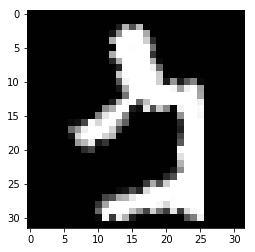

In [206]:
''' sanity check '''
plt.imshow(samples[260].repeat(3,2).squeeze())
plt.show()

In [234]:
all = [samples,xs,maskss,colores,likelihoods]

In [ ]:
''' GATHER FROM BASELINE '''

In [158]:
import pickle as pkl
import numpy as np
import os

root = '/home/lioruzan/human_validation/rand_nocond/'
p = os.path.join(root,'results_{}_human_eval.pkl'.format(0))
with open(p,'rb') as f:
    rand = (pkl.load(f))

In [159]:
samp = np.zeros((0,32,32,1),dtype=np.float32)
data = samp.copy()
mask = samp.copy().astype(np.int32)
colr = np.zeros((0,32,32,3),dtype=np.float32)
prob = np.zeros(len(data), dtype=np.float32)
gen_data = rand['gen_data']
cutoff = rand['size']
total = len(gen_data) * len(gen_data[0][0])
e = total-cutoff
print(total,cutoff,e)
c = 1
for sample_x, x, m, sample_prob, colored_x in gen_data:
    if c == len(gen_data):
        sample_x = sample_x[:-e]
        x = x[:-e]
        m = m[:-e]
        colored_x = colored_x[:-e]
        sample_prob[0] = sample_prob[0][:-e]
    samp = np.vstack([samp, sample_x])
    data = np.vstack([data, x])
    mask = np.vstack([mask, m])
    colr = np.vstack([colr, colored_x])
    prob = np.concatenate([prob, sample_prob[0]])
    c += 1

384 380 4


In [160]:
prob.shape

(380,)

In [135]:
q=d['data'].copy()
np.all(q==data)

True

In [161]:
rand_results = [samp, data, mask, colr, prob]

In [ ]:
''' BASELINE FOR REALSIES '''

In [208]:
import pickle as pkl
import numpy as np
import os

root = '/home/lioruzan/human_validation/baseline/'
p = os.path.join(root,'results_{}_full_human_eval_dir0.pkl'.format(0))
with open(p,'rb') as f:
    base = (pkl.load(f))

In [209]:
samp = np.zeros((0,32,32,1),dtype=np.float32)
data = samp.copy()
mask = samp.copy().astype(np.int32)
colr = np.zeros((0,32,32,3),dtype=np.float32)
prob = np.zeros(len(data), dtype=np.float32)
gen_data = base['gen_data']
cutoff = base['size']
total = len(gen_data) * len(gen_data[0][0])
e = total-cutoff
c = 1
for sample_x, x, m, sample_prob, colored_x in gen_data:
    if c == len(gen_data):
        sample_x = sample_x[:-e]
        x = x[:-e]
        m = m[:-e]
        colored_x = colored_x[:-e]
        sample_prob[0] = sample_prob[0][:-e]
        
    samp = np.vstack([samp, sample_x])
    data = np.vstack([data, x])
    mask = np.vstack([mask, m])
    colr = np.vstack([colr, colored_x])
    print(len(sample_prob[0]))
    prob = np.concatenate([prob, sample_prob[0]])
    
    
    c += 1

48
48
48
48
48
48
48
44


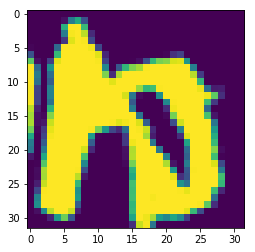

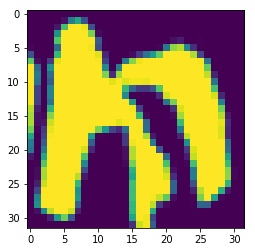

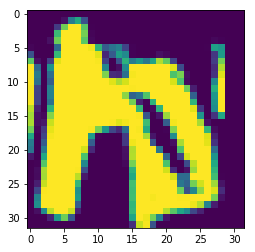

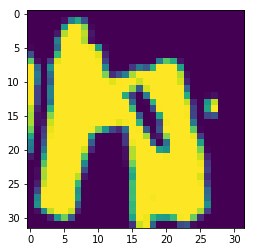

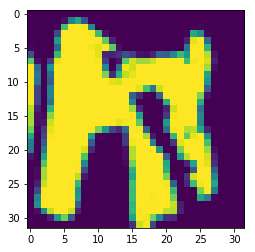

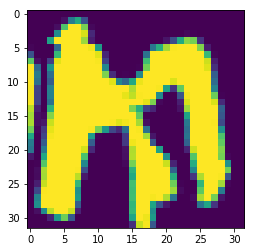

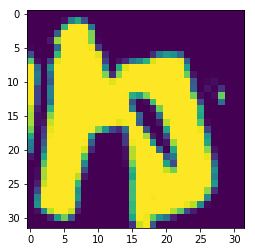

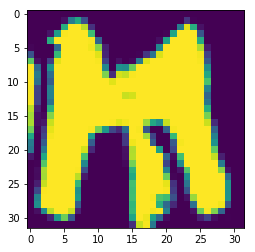

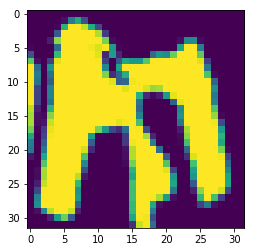

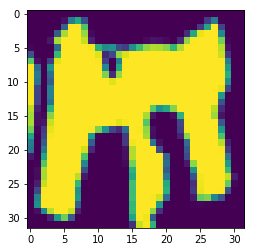

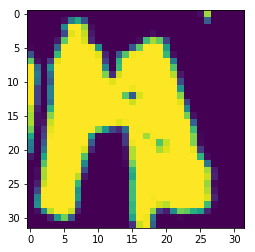

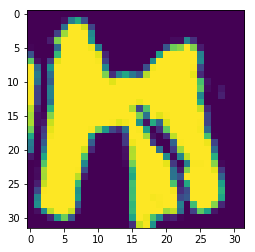

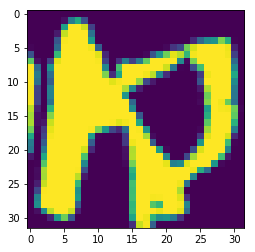

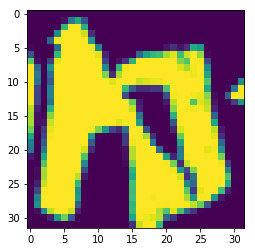

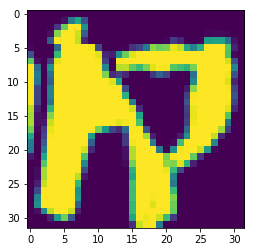

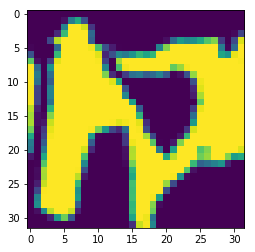

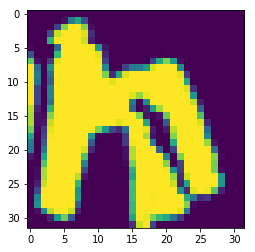

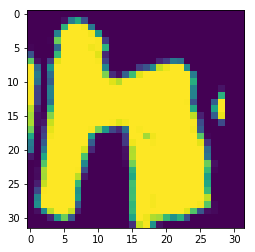

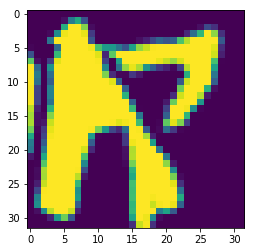

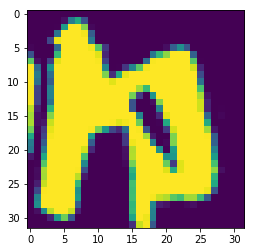

In [212]:
for j in range(200,220):
    plt.imshow(samp[j].squeeze())
    plt.show()

In [154]:
print(len(prob))

380


In [155]:
baseline_results = [samp, data, mask, colr, prob]

In [235]:
''' MISHMASH!! '''
mixed = [np.concatenate([baseline_results[i],rand_results[i]]) for i in range(len(baseline_results))]
mixed2 = [np.concatenate([baseline_results[i],all[i]]) for i in range(len(baseline_results))]

In [236]:
key = np.random.permutation(len(mixed[0]))
root = '/home/lioruzan/human_validation'
# save samples, color samples, log likelihoods
with open(os.path.join(root,'final_samples2.pkl'), 'wb') as f:
    pkl.dump({'baseline':baseline_results,'adaptive':all,'baseline_key':key[:380],'adaptive_key':key[380:],
              'mixed':[o[key] for o in mixed2]},f)

In [180]:
key = np.random.permutation(len(mixed[0]))
root = '/home/lioruzan/human_validation'
# save samples, color samples, log likelihoods
with open(os.path.join(root,'final_samples.pkl'), 'wb') as f:
    pkl.dump({'baseline':baseline_results,'adaptive':rand_results,'baseline_key':key[:380],'adaptive_key':key[380:],
              'mixed':[o[key] for o in mixed]},f)

In [181]:
mixed = [o[key] for o in mixed]

In [238]:
mixed2 = [o[key] for o in mixed2]

In [239]:
root = '/home/lioruzan/human_validation/final_samples/'
for j in range(len(mixed2[0])):
    plt.imsave(os.path.join(root,'%d.png'%j), np.uint8(127.5*mixed2[0][j]+127.5).squeeze(),cmap=plt.cm.gray)

In [207]:
''' view completions '''
import matplotlib.pyplot as plt
# r = np.random.randperm()
sep = np.zeros((32,2,3),dtype=np.float32)
cc=1
for i in range(200,len(colrs[0])):
    if cc == 20:
        break
    x = (datas[0][i].repeat(3,2)-127.5)/127.5
    im = np.concatenate([colrs[0][i],sep,x],axis=1)
    plt.imshow(np.squeeze(im))
    plt.show()
    cc+=1

In [ ]:
''' PSNR CALCULATOR '''

In [4]:
import pickle as pkl
import numpy as np
import os

root = '/home/lioruzan/latest_checkpoints'
runs = [[] for j in range(8)]
for i in range(8):
    if i==6: continue # nothing 
    r = os.path.join(root,'dir%d'%i)
    for j in range(20):
        p = os.path.join(r,'results_{}.pkl'.format(j))
        with open(p,'rb') as f:
            runs[i].append(pkl.load(f))

In [7]:
# format of pickled files: {'gen_data': ( sample_x, x, m, sample_prob, colored_x ), 'size': size}
samps = []
datas = []
masks = []
colrs = []
probs = []
# collect generates samples from all 8 models for each experiment (20 total)
for j in range(1):
    samp = np.zeros((0,32,32,1),dtype=np.float32)
    data = samp.copy()
    mask = samp.copy().astype(np.int32)
    colr = np.zeros((0,32,32,3),dtype=np.float32)
    prob = np.zeros(len(data), dtype=np.float32)
    for i in range(8):
        if i==7: continue
        gen_data = runs[i][j]['gen_data']
        cutoff = runs[i][j]['size']
        total = len(gen_data) * len(gen_data[0][0])
        e = total-cutoff
        c = 1
        for sample_x, x, m, sample_prob, colored_x in gen_data:
            if c == len(gen_data):
                sample_x = sample_x[:-e]
                x = x[:-e]
                m = m[:-e]
                colored_x = colored_x[:-e]
                sample_prob = sample_prob[:-e]
            samp = np.vstack([samp, sample_x])
            data = np.vstack([data, x])
            mask = np.vstack([mask, m])
            colr = np.vstack([colr, colored_x])
            prob = np.concatenate([prob, sample_prob])
            c += 1
    samps.append(samp)
    datas.append(data)
    masks.append(mask)
    colrs.append(colr)
    probs.append(prob)

In [ ]:
average_psnrs=[]
std_psnrs=[]
for run in range(20):
    # calculate mean average psnr
    mses = []
    sample_x = samps[run]
    x = datas[run]
    # calculate per-picture psnr vectorized
    #change to 0..255
    a = np.round(127.5 * sample_x + 127.5)
    b = x
    mse = np.sum( np.power(a-b,2), axis=(1,2,3) ) / np.prod( a.shape[1:] ) # ignore batch size
    
    # discard all samples from padding
    
    psnrs = 20 * ( np.log10(255) - np.log10( np.sqrt(mse) ) )
    psnr_avg, psnr_std = np.mean(psnrs), np.std(psnrs)
    print("average psnr run {}: {}, std: {}".format(run, psnr_avg, psnr_std))
    average_psnrs.append(psnr_avg)
    std_psnrs.append(psnr_std)
    
# show stats summary
if len(average_psnrs)>0:
    print("mean average psnr: {}, std over averages: {}, mean psnr std: {}, std over stds: {}".format(
            np.mean(average_psnrs), np.std(average_psnrs),
            np.mean(std_psnrs), np.std(std_psnrs)))

In [1]:
''' OLD VERSION '''
import pickle as pkl
import numpy as np
import os.path as osp
import os

''' stitch together 4-model adaptive rotation results '''

root = '/home/lioruzan/checkpoints'
runs= [[] for j in range(4)]
for i in range(4):
    r = os.path.join(root,str(i))
    for j in range(10):
        p = os.path.join(r,'results_{}.pkl'.format(j))
        with open(p,'rb') as f:
            runs[i].append(pkl.load(f))
            

runss=[]
for j in range(10):
    samp=np.zeros((0,32,32,3))
    data=samp.copy()
    mask=data.copy()
    for i in range(4):
        for sample,(x,m) in runs[i][j]:
            sample = np.rot90(sample, k=-i, axes=(1,2))
            x = np.rot90(x, k=-i, axes=(1,2))
            m = np.rot90(m, k=-i, axes=(1,2))
            samp = np.vstack([samp,sample])
            data = np.vstack([data,x])
            mask = np.vstack([mask,m])
    runss.append((samp,data,mask))


In [4]:

''' calculate mean average psnr (+- mean average std)'''
average_psnrs, std_psnrs = [], []
for o, data, _ in runss:
    psnrs=[]
    for i in range(o.shape[0]):
        #change to 0..255
        x = np.round(127.5 * o[i] + 127.5)
        y = data[i]
        #mse
        mse = np.sum( np.power(x-y,2) ) / np.prod( x.shape )
        #psnr
        psnr = 20 * ( np.log10(255) - np.log10(np.sqrt(mse)) )
        psnrs.append(psnr)
        
    psnr_avg, psnr_std = np.mean(psnrs), np.std(psnrs)
    average_psnrs.append(psnr_avg)
    std_psnrs.append(psnr_std)
print('{:.5} +-{:.5}'.format(np.mean(average_psnrs), np.mean(std_psnrs)))


13.317 +-4.3397


In [ ]:

''' visualize results '''
p=np.random.randint(140)
plt.imshow(runss[0][1][p]/127.5-1)
plt.show()
plt.imshow((runss[0][1][p]/127.5-1)*runss[0][2][p])
plt.show()
plt.imshow(runss[0][0][p])
plt.show()